# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
from skimage.transform import rescale,resize
from skimage import io
import os
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [ ]:
from tensorflow.keras.layers import Flatten,Dense,TimeDistributed,GRU,Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

Load the data path and set the batch size.

In [ ]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size =  10  #experiment with the batch size

In [ ]:
print(train_doc.shape)
print(val_doc.shape)
train_doc[:5]

(663,)
(100,)


array(['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n'],
      dtype='<U88')

(120, 160, 3)


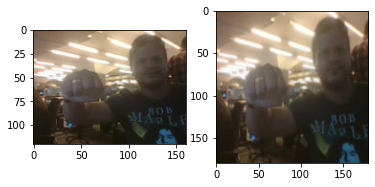

In [ ]:
# import a sample image and visualise
from glob import glob
source_path = './Project_data/train'
path = os.path.join(source_path,train_doc[1].split(';')[0],'*')
vid_img_path = glob(path)
print(io.imread(vid_img_path[6]).shape)
f, axes = plt.subplots(1,2)
axes[0].imshow(io.imread(vid_img_path[1]))
axes[1].imshow(resize(io.imread(vid_img_path[1]), (180,180)))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

1) Batch size
2) num of frames
3) crop and resize
4) normalisation
5) handles extra samples (yield one extra batch with lessed samples)

In [ ]:
def generator(source_path, folder_list, batch_size, exp_img_shape):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0,30,2)
    #print(img_idx) #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y,z = exp_img_shape # desired image shape
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        
        # Take each batch of video for further processing 
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
           
        # treat the frames in each video
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image, (y,z))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            print("-----Batch{0}: size: {1}".format(batch,batch_size))
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        if ((len(t) % batch_size) != 0) and (batch == num_batches-1):
            bs = len(t) - (num_batches*batch_size)
            batch_data = np.zeros((bs,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((bs,5)) # batch_labels is the one hot representation of the output
        # treat the frames in each video
            for folder in range(bs): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + num_batches*batch_size].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image, (y,z))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            print("-----last Batch size: {0}".format(bs))
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

            
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'

train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 16 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 16


In [ ]:
# function to set variables such as steps_per_epoch etc.
def sample_set(batch_size, set_size, exp_img_shape):
    if set_size!= len(train_doc):
        data_set = np.random.permutation(train_doc)[:set_size]
    else:
        data_set = train_doc.copy()
    train_generator = generator(train_path, data_set, batch_size, exp_img_shape)
    val_generator = generator(val_path, val_doc, batch_size, exp_img_shape)
    num_train_sequences = len(data_set)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    print('num_train_sequences:{0}, num_val_sequences:{1}, steps_per_epoch:{2}, validation_steps:{3}'.format(num_train_sequences,num_val_sequences,steps_per_epoch, validation_steps))
    return (train_generator,val_generator,steps_per_epoch,validation_steps)

In [ ]:
# save the weights of the model for each epoch
# provide option to select desired model evalutaion parameter
def save_model(eval_param):
    curr_dt_time = datetime.datetime.now()
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{'+eval_param+':.5f}-{val_loss:.5f}-{val_'+eval_param+':.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

    LR =   ReduceLROnPlateau(monitor = 'val_loss', factor=0.1, patience = 5) # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]
    return(callbacks_list)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

- Types of models to experiment with
    - CNN 3D model
    - Transfer Learning: CNN+GRU
    - Transfer Learning: CNN+LSTM
    - customized CNN+ GRU

### Conv3D models

##### Model 1

In [ ]:
# Conv3D model
def cnn_1(inp_shape):
    model = Sequential()
    model.add(Conv3D(32, kernel_size = (2,2,2), strides =1, activation = 'relu', input_shape = inp_shape))
    model.add(Conv3D(64, kernel_size = (2,2,2), strides =1,activation = 'relu', padding = 'same'))

    model.add(Conv3D(64, kernel_size = (2,2,2), strides =1,activation = 'relu', padding = 'same'))
    model.add(MaxPooling3D(pool_size = (2,2,2)))

    model.add(Conv3D(128, kernel_size = (2,2,2), strides =1, activation = 'relu', padding = 'same'))
    model.add(MaxPooling3D(pool_size = (2,2,2)))

    model.add(Conv3D(128, kernel_size = (2,2,2), strides =1, activation = 'relu', padding = 'same'))
    model.add(MaxPooling3D(pool_size = (2,2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.3))

    model.add(Dense(5, activation = 'softmax'))
    return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
# use Adam with learning rate = 0.001
optimiser = 'Adam' #write your optimizer
model = cnn_1((15,180,180,3))
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 179, 179, 32)  800       
                                                                 
 conv3d_1 (Conv3D)           (None, 14, 179, 179, 64)  16448     
                                                                 
 conv3d_2 (Conv3D)           (None, 14, 179, 179, 64)  32832     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 89, 89, 64)    0         
 )                                                               
                                                                 
 conv3d_3 (Conv3D)           (None, 7, 89, 89, 128)    65664     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 44, 44, 128)   0         
 3D)                                                    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
# ABLATION
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set(20,100,(180,180))
callbacks_list = save_model('categorical_accuracy')
num_epochs =16

num_train_sequences:100, num_val_sequences:100, steps_per_epoch:5, validation_steps:5


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

-----Batch0: size: 20
Epoch 1/16
-----Batch1: size: 20
5/5 [==============================] - ETA: 0s - loss: 1.6547 - categorical_accuracy: 0.1800  -----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20

Epoch 00001: saving model to model_init_2021-12-2713_35_44.155618\model-00001-1.65472-0.18000-1.60342-0.18000.h5
5/5 [==============================] - 1031s 209s/step - loss: 1.6547 - categorical_accuracy: 0.1800 - val_loss: 1.6034 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/16
-----Batch1: size: 20
5/5 [==============================] - ETA: 0s - loss: 1.6046 - categorical_accuracy: 0.1900  -----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20

Epoch 00002: saving model to model_init_2021-12-2713_35_44.155618\model-00002-1.60462-0.19000-1.59961-0.16000.h5
5/5 [==============================] - 827s 168s/step - loss: 1.

Model 1 is able to overfit on the sample dateset, hence try training the model on complete dataset

In [ ]:
### Training on complete dataset
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set(20,len(train_doc),(180,180))
callbacks_list = save_model('categorical_accuracy')

num_train_sequences:663, num_val_sequences:100, steps_per_epoch:34, validation_steps:5


In [ ]:
### Training on complete dataset
num_epochs =16
model = cnn_1((15,180,180,3))
optimiser = 'Adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

- Number of trainable paraemeters = 4,212,261
- Categorical accuracy at the end of epoch 16:  Train data: 0.97, validation data: 0.85 
- Categorical accuracy at epoch 9: Train data: 0.88, validation data: 0.84 
- Model with parameters obtained at the end of epoch 9 is more suitable as it has no overfitting compared to the results at the end of epoch 16 

##### Let's try a slightly different image preprocessing. Crop the image with an offset of 15 pixels at every side and then resize

In [ ]:
def generator_crop(source_path, folder_list, batch_size, exp_img_shape):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0,30,2)
    #print(img_idx) #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y,z = exp_img_shape 
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        
        # Take each batch of video for further processing 
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
           
        # treat the frames in each video
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = image[15:image.shape[0]-15+1,15:image.shape[1]-15+1,:]
                    image = resize(image, (y,z))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            print("-----Batch{0}: size: {1}".format(batch,batch_size))
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        if ((len(t) % batch_size) != 0) and (batch == num_batches-1):
            bs = len(t) - (num_batches*batch_size)
            batch_data = np.zeros((bs,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((bs,5)) # batch_labels is the one hot representation of the output
        # treat the frames in each video
            for folder in range(bs): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + num_batches*batch_size].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = image[15:image.shape[0]-15+1,15:image.shape[1]-15+1,:]
                    image = resize(image, (y,z))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            print("-----last Batch size: {0}".format(bs))
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

            
        # write the code for the remaining data points which are left after full batches

def sample_set_crop(batch_size, set_size,exp_img_shape):
    if set_size!= len(train_doc):
        data_set = np.random.permutation(train_doc)[:set_size]
    else:
        data_set = train_doc.copy()
    train_generator = generator_crop(train_path, data_set, batch_size,exp_img_shape)
    val_generator = generator_crop(val_path, val_doc, batch_size,exp_img_shape)
    num_train_sequences = len(data_set)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    print('num_train_sequences:{0}, num_val_sequences:{1}, steps_per_epoch:{2}, validation_steps:{3}'.format(num_train_sequences,num_val_sequences,steps_per_epoch, validation_steps))
    return (train_generator,val_generator,steps_per_epoch,validation_steps)

#### Model 2- Only difference with model 1 is in the input image shape and the image preprocessing steps

In [ ]:
# ABLATION
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set_crop(20,100,(130,130))
callbacks_list = save_model('categorical_accuracy')
num_epochs = 16
optimiser = 'Adam' #write your optimizer
model = cnn_1((15,130,130,3))
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

num_train_sequences:100, num_val_sequences:100, steps_per_epoch:5, validation_steps:5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 129, 129, 32)  800       
                                                                 
 conv3d_1 (Conv3D)           (None, 14, 129, 129, 64)  16448     
                                                                 
 conv3d_2 (Conv3D)           (None, 14, 129, 129, 64)  32832     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 64, 64, 64)    0         
 )                                                               
                                                                 
 conv3d_3 (Conv3D)           (None, 7, 64, 64, 128)    65664     
                                                                 
 max_pooling3d_1 (MaxPooling  (None,

Model is able to overfit on the newly processed data. Let's try to train the model fully

In [ ]:
### Training on complete dataset
callbacks_list = save_model('categorical_accuracy')
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set_crop(20,len(train_doc),(130,130))
model = cnn_1((15,130,130,3))
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

num_train_sequences:663, num_val_sequences:100, steps_per_epoch:34, validation_steps:5


In [ ]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

-----Batch0: size: 20
Epoch 1/16
-----Batch1: size: 20
34/34 [==============================] - ETA: 0s - loss: 1.6320 - categorical_accuracy: 0.2232  -----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20

Epoch 00001: saving model to model_init_2021-12-2822_04_44.919280\model-00001-1.63202-0.22323-1.50268-0.37000.h5
34/34 [==============================] - 3819s 111s/step - loss: 1.6320 - categorical_accuracy: 0.2232 - val_loss: 1.5027 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/16
-----Batch1: size: 20
34/34 [==============================] - ETA: 0s - loss: 1.3520 - categorical_accuracy: 0.4268  -----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20

Epoch 00002: saving model to model_init_2021-12-2822_04_44.919280\model-00002-1.35196-0.42685-1.07697-0.58000.h5
34/34 [==============================] - 2219s 65s/step - 

34/34 [==============================] - ETA: 0s - loss: 0.7248 - categorical_accuracy: 0.7104  -----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20

Epoch 00004: saving model to model_init_2021-12-2822_04_44.919280\model-00004-0.72485-0.71041-0.65906-0.81000.h5
34/34 [==============================] - 2635s 78s/step - loss: 0.7248 - categorical_accuracy: 0.7104 - val_loss: 0.6591 - val_categorical_accuracy: 0.8100 - lr: 0.0010
Epoch 5/16
-----Batch1: size: 20
34/34 [==============================] - ETA: 0s - loss: 0.5662 - categorical_accuracy: 0.7738  -----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20

Epoch 00005: saving model to model_init_2021-12-2822_04_44.919280\model-00005-0.56619-0.77376-0.68929-0.83000.h5
34/34 [==============================] - 2153s 63s/step - loss: 0.5662 - categorical_accuracy: 0.7738 - val_loss: 

34/34 [==============================] - ETA: 0s - loss: 0.2329 - categorical_accuracy: 0.9216  -----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20

Epoch 00008: saving model to model_init_2021-12-2822_04_44.919280\model-00008-0.23288-0.92157-0.86621-0.79000.h5
34/34 [==============================] - 2143s 63s/step - loss: 0.2329 - categorical_accuracy: 0.9216 - val_loss: 0.8662 - val_categorical_accuracy: 0.7900 - lr: 0.0010
Epoch 9/16
-----Batch1: size: 20
34/34 [==============================] - ETA: 0s - loss: 0.2616 - categorical_accuracy: 0.9020  -----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20

Epoch 00009: saving model to model_init_2021-12-2822_04_44.919280\model-00009-0.26158-0.90196-0.61915-0.85000.h5
34/34 [==============================] - 2147s 63s/step - loss: 0.2616 - categorical_accuracy: 0.9020 - val_loss: 

34/34 [==============================] - ETA: 0s - loss: 0.1536 - categorical_accuracy: 0.9487  -----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20

Epoch 00011: saving model to model_init_2021-12-2822_04_44.919280\model-00011-0.15360-0.94872-0.71227-0.84000.h5
34/34 [==============================] - 2142s 63s/step - loss: 0.1536 - categorical_accuracy: 0.9487 - val_loss: 0.7123 - val_categorical_accuracy: 0.8400 - lr: 0.0010
Epoch 12/16
-----Batch1: size: 20
34/34 [==============================] - ETA: 0s - loss: 0.1110 - categorical_accuracy: 0.9713  -----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20

Epoch 00012: saving model to model_init_2021-12-2822_04_44.919280\model-00012-0.11105-0.97134-0.57957-0.89000.h5
34/34 [==============================] - 2144s 63s/step - loss: 0.1110 - categorical_accuracy: 0.9713 - val_loss:

34/34 [==============================] - ETA: 0s - loss: 0.0747 - categorical_accuracy: 0.9804  -----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20

Epoch 00015: saving model to model_init_2021-12-2822_04_44.919280\model-00015-0.07469-0.98039-1.02087-0.89000.h5
34/34 [==============================] - 2146s 63s/step - loss: 0.0747 - categorical_accuracy: 0.9804 - val_loss: 1.0209 - val_categorical_accuracy: 0.8900 - lr: 1.0000e-04
Epoch 16/16
-----Batch1: size: 20
34/34 [==============================] - ETA: 0s - loss: 0.0622 - categorical_accuracy: 0.9834  -----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20

Epoch 00016: saving model to model_init_2021-12-2822_04_44.919280\model-00016-0.06221-0.98341-0.79662-0.86000.h5
34/34 [==============================] - 2158s 63s/step - loss: 0.0622 - categorical_accuracy: 0.9834 - val_l

Observations:
- Categorical accuracy at the end of epoch 16:  Train data: 0.98, validation data: 0.86 
- Categorical accuracy at epoch 14: Train data: 0.98, validation data: 0.91 
- So, model obtained at the end of epoch 14 seems suitable

In [ ]:
tf.keras.backend.clear_session()

### Transfer learning: CNN (Resnet) + RNN (GRU)

#### Model#3: Use Resnet50 with last 10 layers weights being retrained along with GRU

In [ ]:
## model 3
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(180,180,3))
for layer in resnet.layers[:-10]:
    layer.trainable=False
cnn =Sequential([resnet])
cnn.add(Conv2D(64,(2,2),strides=(1,1)))
cnn.add(Conv2D(128,(2,2),strides=(1,1)))
cnn.add(Conv2D(128,(2,2), strides= (1,1)))
cnn.add(Conv2D(128,(2,2), strides= (1,1)))
cnn.add(Flatten())
model = Sequential()
model.add(TimeDistributed(cnn,input_shape=(15,180,180,3)))
model.add(GRU(32,input_shape=(None,15,512),return_sequences=True))
model.add(GRU(16))
model.add(Dense(5,activation='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 15, 512)          24276288  
 stributed)                                                      
                                                                 
 gru_11 (GRU)                (None, 15, 32)            52416     
                                                                 
 gru_12 (GRU)                (None, 16)                2400      
                                                                 
 dense_7 (Dense)             (None, 5)                 85        
                                                                 
Total params: 24,331,189
Trainable params: 5,209,141
Non-trainable params: 19,122,048
_________________________________________________________________


In [ ]:
## ABLATION
# Let's use a learning rate of 0.0001 to improve learning
num_epochs = 8
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set(8,150,(180,180))
callbacks_list = save_model('categorical_accuracy')
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['categorical_accuracy'])
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

num_train_sequences:150, num_val_sequences:100, steps_per_epoch:19, validation_steps:13
-----Batch0: size: 8
Epoch 1/5
-----Batch1: size: 8
19/19 [==============================] - ETA: 0s - loss: 1.7358 - categorical_accuracy: 0.1667-----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8

Epoch 00001: saving model to model_init_2021-12-2816_24_42.038728\model-00001-1.73584-0.16667-1.61505-0.22000.h5
19/19 [==============================] - 258s 13s/step - loss: 1.7358 - categorical_accuracy: 0.1667 - val_loss: 1.6150 - val_categorical_accuracy: 0.2200 - lr: 1.0000e-04
Epoch 2/5
-----Batch1: size: 8
19/19 [==============================] - ETA: 0s - loss: 1.6366 - categorical_accuracy: 0.1867-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: s

-----last Batch size: 4
-----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8

Epoch 00003: saving model to model_init_2021-12-2816_24_42.038728\model-00003-1.60852-0.24667-1.60178-0.18000.h5
19/19 [==============================] - 248s 13s/step - loss: 1.6085 - categorical_accuracy: 0.2467 - val_loss: 1.6018 - val_categorical_accuracy: 0.1800 - lr: 1.0000e-04
Epoch 4/5
-----Batch1: size: 8
19/19 [==============================] - ETA: 0s - loss: 1.5786 - categorical_accuracy: 0.2933-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8

Epoch 00004: saving model to model_init_2021-12-2816_24_42.038728\model-00004-1.57858-0.29333-1.56129-0.27000.h5
19/19 [==============================] - 247s 13s/step - loss: 1.5786 - categorical_accur

Observations:
- Model doesn't seem to overfit easily on the sample data. Let's try to increase the ResNet layers to be retrained from 10 to last 20 layers.

#### Model#4: ResNet layers to be retrained: last 20

In [ ]:
## model 4
def res_cnn_1():
    resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(180,180,3))
    for layer in resnet.layers[:-20]:
        layer.trainable=False
    cnn =Sequential([resnet])
    cnn.add(Conv2D(64,(2,2),strides=(1,1)))
    cnn.add(Conv2D(128,(2,2),strides=(1,1)))
    cnn.add(Conv2D(128,(2,2), strides= (1,1)))
    cnn.add(Conv2D(128,(2,2), strides= (1,1)))
    cnn.add(Flatten())
    model = Sequential()
    model.add(TimeDistributed(cnn,input_shape=(15,180,180,3)))
    model.add(GRU(32,input_shape=(None,15,512),return_sequences=True))
    model.add(GRU(16))
    model.add(Dense(5,activation='softmax'))
    print(model.summary())
    return(model)

In [ ]:
model = res_cnn_1()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 512)          24276288  
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 15, 32)            52416     
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dense (Dense)               (None, 5)                 85        
                                                                 
Total params: 24,331,189
Trainable params: 9,674,805
Non-trainable params: 14,656,384
_________________________________________________________________
None


In [ ]:
## ABLATION
num_epochs = 5
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set(8,150,(180,180))
callbacks_list = save_model('categorical_accuracy')
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['categorical_accuracy'])
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

num_train_sequences:150, num_val_sequences:100, steps_per_epoch:19, validation_steps:13
-----Batch0: size: 8
Epoch 1/5
-----Batch1: size: 8
19/19 [==============================] - ETA: 0s - loss: 1.6649 - categorical_accuracy: 0.2600 -----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8

Epoch 00001: saving model to model_init_2021-12-2816_49_59.228771\model-00001-1.66494-0.26000-1.68490-0.24000.h5


C:\Users\veena\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


19/19 [==============================] - 268s 14s/step - loss: 1.6649 - categorical_accuracy: 0.2600 - val_loss: 1.6849 - val_categorical_accuracy: 0.2400 - lr: 1.0000e-04
Epoch 2/5
-----Batch1: size: 8
19/19 [==============================] - ETA: 0s - loss: 1.6362 - categorical_accuracy: 0.2667 -----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8
-----Batch1: size: 8

Epoch 00002: saving model to model_init_2021-12-2816_49_59.228771\model-00002-1.63618-0.26667-1.65127-0.16000.h5
19/19 [==============================] - 261s 14s/step - loss: 1.6362 - categorical_accuracy: 0.2667 - val_loss: 1.6513 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04
Epoch 3/5
-----Batch1: size: 8
19/19 [==============================] - ETA: 0s - loss: 1.5520 - categorical_accuracy

-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8

Epoch 00004: saving model to model_init_2021-12-2816_49_59.228771\model-00004-1.52374-0.31333-1.66005-0.17000.h5
19/19 [==============================] - 265s 14s/step - loss: 1.5237 - categorical_accuracy: 0.3133 - val_loss: 1.6601 - val_categorical_accuracy: 0.1700 - lr: 1.0000e-04
Epoch 5/5
-----Batch1: size: 8
19/19 [==============================] - ETA: 0s - loss: 1.5163 - categorical_accuracy: 0.3667 -----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8

Epoch 00005: saving model to model_init_2021-12-2816_49_59.228771\model-00005-1.51630-0.36667-1.59482-0.17000.h5
19/19 [================

Observations:
- model seems to be learning progressively over the epochs and shows symptoms of overfitting. So, let's try to perform complete training

In [ ]:
num_epochs = 16
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set(20,len(train_doc),(180,180))
callbacks_list = save_model('categorical_accuracy')
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model = res_cnn_1()
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['categorical_accuracy'])
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

num_train_sequences:663, num_val_sequences:100, steps_per_epoch:34, validation_steps:5
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeDi  (None, 15, 512)          24276288  
 stributed)                                                      
                                                                 
 gru_17 (GRU)                (None, 15, 32)            52416     
                                                                 
 gru_18 (GRU)                (None, 16)                2400      
                                                                 
 dense_10 (Dense)            (None, 5)                 85        
                                                                 
Total params: 24,331,189
Trainable params: 9,674,805
Non-trainable params: 14,656,384
_________________________________________________________________
None
-----Ba

C:\Users\veena\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


34/34 [==============================] - 963s 28s/step - loss: 1.6219 - categorical_accuracy: 0.2293 - val_loss: 1.6228 - val_categorical_accuracy: 0.1800 - lr: 1.0000e-04
Epoch 2/16
-----Batch1: size: 20
34/34 [==============================] - ETA: 0s - loss: 1.5951 - categorical_accuracy: 0.2428 -----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20

Epoch 00002: saving model to model_init_2021-12-2817_15_33.974604\model-00002-1.59514-0.24284-1.60388-0.33000.h5
34/34 [==============================] - 954s 28s/step - loss: 1.5951 - categorical_accuracy: 0.2428 - val_loss: 1.6039 - val_categorical_accuracy: 0.3300 - lr: 1.0000e-04
Epoch 3/16
-----Batch1: size: 20
34/34 [==============================] - ETA: 0s - loss: 1.5584 - categorical_accuracy: 0.2790 -----Batch0: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20


34/34 [==============================] - ETA: 0s - loss: 1.4489 - categorical_accuracy: 0.3967 -----Batch0: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20

Epoch 00005: saving model to model_init_2021-12-2817_15_33.974604\model-00005-1.44888-0.39668-1.58829-0.31000.h5
34/34 [==============================] - 974s 29s/step - loss: 1.4489 - categorical_accuracy: 0.3967 - val_loss: 1.5883 - val_categorical_accuracy: 0.3100 - lr: 1.0000e-04
Epoch 6/16
-----Batch1: size: 20
34/34 [==============================] - ETA: 0s - loss: 1.3699 - categorical_accuracy: 0.4178 -----Batch0: size: 20
-----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20

Epoch 00006: saving model to model_init_2021-12-2817_15_33.974604\model-00006-1.36993-0.41780-1.46603-0.38000.h5
34/34 [==============================] - 988s 29s/step - loss: 1.3699

34/34 [==============================] - ETA: 0s - loss: 1.3128 - categorical_accuracy: 0.4751 -----Batch0: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20

Epoch 00009: saving model to model_init_2021-12-2817_15_33.974604\model-00009-1.31276-0.47511-1.40048-0.45000.h5
34/34 [==============================] - 1040s 31s/step - loss: 1.3128 - categorical_accuracy: 0.4751 - val_loss: 1.4005 - val_categorical_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 10/16
-----Batch1: size: 20
34/34 [==============================] - ETA: 0s - loss: 1.2763 - categorical_accuracy: 0.5279 -----Batch0: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20

Epoch 00010: saving model to model_init_2021-12-2817_15_33.974604\model-00010-1.27628-0.52790-1.33477-0.48000.h5
34/34 [==============================] - 1058s 31s/step - loss: 1.2

34/34 [==============================] - ETA: 0s - loss: 1.1790 - categorical_accuracy: 0.5611 -----Batch0: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20

Epoch 00013: saving model to model_init_2021-12-2817_15_33.974604\model-00013-1.17896-0.56109-1.42652-0.39000.h5
34/34 [==============================] - 1040s 31s/step - loss: 1.1790 - categorical_accuracy: 0.5611 - val_loss: 1.4265 - val_categorical_accuracy: 0.3900 - lr: 1.0000e-04
Epoch 14/16
-----Batch1: size: 20
34/34 [==============================] - ETA: 0s - loss: 1.0960 - categorical_accuracy: 0.6199 -----Batch0: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20

Epoch 00014: saving model to model_init_2021-12-2817_15_33.974604\model-00014-1.09601-0.61991-1.57793-0.35000.h5
34/34 [==============================] - 1054s 31s/step - loss: 1.0

34/34 [==============================] - ETA: 0s - loss: 1.0366 - categorical_accuracy: 0.6395 -----Batch0: size: 20
-----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20

Epoch 00016: saving model to model_init_2021-12-2817_15_33.974604\model-00016-1.03660-0.63952-1.53218-0.41000.h5
34/34 [==============================] - 1476s 44s/step - loss: 1.0366 - categorical_accuracy: 0.6395 - val_loss: 1.5322 - val_categorical_accuracy: 0.4100 - lr: 1.0000e-04


Observations
- Categorical accuracy at the end of epoch 16:  Train data: 0.63, validation data: 0.41 
- Model accuracy on train data is comparatively less and is heavily overfitting. 

#### Model#5: Retrain all layers of ResNet

In [ ]:
# model 5
def res_rnn():
    resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(180,180,3))
    cnn =Sequential([resnet])
    cnn.add(Conv2D(64,(2,2),strides=(1,1)))
    cnn.add(Conv2D(128,(2,2),strides=(1,1)))
    cnn.add(Conv2D(128,(2,2), strides= (1,1)))
    cnn.add(Flatten())
    print(cnn.summary())
    model = Sequential()
    model.add(TimeDistributed(cnn,input_shape=(15,180,180,3)))
    model.add(GRU(32,input_shape=(None,15,1152),return_sequences=True))
    model.add(GRU(64))
    model.add(Dense(5,activation='softmax'))
    print(model.summary())
    return model

In [ ]:
model = res_rnn()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 64)          524352    
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         32896     
                                                                 
 conv2d_6 (Conv2D)           (None, 3, 3, 128)         65664     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
Total params: 24,210,624
Trainable params: 24,157,504
Non-trainable params: 53,120
_________________________________________________________________
None
Model: "sequential_3"
__________

In [ ]:
## ABLATION
num_epochs = 5
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set(8,150,(180,180))
callbacks_list = save_model('categorical_accuracy')
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['categorical_accuracy'])
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

num_train_sequences:150, num_val_sequences:100, steps_per_epoch:19, validation_steps:13
-----Batch0: size: 8
Epoch 1/5
-----Batch1: size: 8
19/19 [==============================] - ETA: 0s - loss: 1.3981 - categorical_accuracy: 0.4133 -----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8

Epoch 00001: saving model to model_init_2021-12-2815_39_25.497505\model-00001-1.39808-0.41333-1.71831-0.24000.h5
19/19 [==============================] - 833s 44s/step - loss: 1.3981 - categorical_accuracy: 0.4133 - val_loss: 1.7183 - val_categorical_accuracy: 0.2400 - lr: 1.0000e-04
Epoch 2/5
-----Batch1: size: 8
19/19 [==============================] - ETA: 0s - loss: 0.5251 - categorical_accuracy: 0.9667 -----Batch1: size: 8
-----Batch2: size: 8
-----Batch3:

KeyboardInterrupt: 

Model is able to learn well with a learning rate of 0.0001. However, the number of trainable parameters is very high causing large training time. Since good accuracy can be achieved by other models with less trainable parameters, no need to pursue this model further.

#### Include all available frames for training:
Include all available frames of videos for training purpose and observe the results

In [ ]:
def generator_frame(source_path, folder_list, batch_size, exp_img_shape):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0,30)
    #print(img_idx) #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y,z = exp_img_shape
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        
        # Take each batch of video for further processing 
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
           
        # treat the frames in each video
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image, (y,z))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            print("-----Batch{0}: size: {1}".format(batch,batch_size))
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        if ((len(t) % batch_size) != 0) and (batch == num_batches-1):
            bs = len(t) - (num_batches*batch_size)
            batch_data = np.zeros((bs,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((bs,5)) # batch_labels is the one hot representation of the output
        # treat the frames in each video
            for folder in range(bs): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + num_batches*batch_size].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image, (y,z))
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            print("-----last Batch size: {0}".format(bs))
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

            
        # write the code for the remaining data points which are left after full batches
def sample_set_frame(batch_size, set_size,exp_img_shape):
    if set_size!= len(train_doc):
        data_set = np.random.permutation(train_doc)[:set_size]
    else:
        data_set = train_doc.copy()
    train_generator = generator_frame(train_path, data_set, batch_size,exp_img_shape)
    val_generator = generator_frame(val_path, val_doc, batch_size,exp_img_shape)
    num_train_sequences = len(data_set)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    print('num_train_sequences:{0}, num_val_sequences:{1}, steps_per_epoch:{2}, validation_steps:{3}'.format(num_train_sequences,num_val_sequences,steps_per_epoch, validation_steps))
    return (train_generator,val_generator,steps_per_epoch,validation_steps)

#### Model#6: Retrain last 10 layers of ResNet, with GRU on top of it

In [ ]:
# model 6
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(180,180,3))
for layer in resnet.layers[:-10]:
    layer.trainable=False
cnn =Sequential([resnet])
cnn.add(Flatten())
model = Sequential()
model.add(TimeDistributed(cnn,input_shape=(30,180,180,3)))
model.add(GRU(32,input_shape=(None,30,73728),return_sequences=True))
model.add(GRU(64))
model.add(Dense(5,activation='softmax'))
model.summary()

In [ ]:
## ABLATION
num_epochs = 8
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set_frame(8,150,(180,180))
callbacks_list = save_model('accuracy')
opt = tf.keras.optimizers.Adam(learning_rate=0.001) 
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

Model is unable to overfit on smaller dataset itself. Need to change model layers and experiment. Since similar performance can be achieved with less number of frames, no need to pursue further with all 30 frames for training

#### Model#7: ResNet with last 15 layers to be retrained, image shape = 130x130x3

In [ ]:
tf.keras.backend.clear_session()
def res_rnn_1():
    resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(130,130,3))
    for layer in resnet.layers[:-15]:
        layer.trainable=False
    cnn =Sequential([resnet])
    cnn.add(Conv2D(512,(2,2),strides=(1,1)))
    cnn.add(Conv2D(512,(2,2),strides=(1,1)))
    cnn.add(MaxPooling2D(2,2))
    cnn.add(Dense(128, activation ='relu'))
    cnn.add(Dense(128, activation ='relu'))
    cnn.add(Flatten())
    print(cnn.summary())
    model = Sequential()
    model.add(TimeDistributed(cnn,input_shape=(15,130,130,3)))
    model.add(GRU(128,input_shape=(None,15,128),return_sequences=True))
    model.add(GRU(128, return_sequences = True))
    model.add(GRU(64))
    model.add(Dense(5,activation='softmax'))
    print(model.summary())
    return model

In [ ]:
model = res_rnn_1()
opt = tf.keras.optimizers.Adam(learning_rate=0.001) 
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 512)         4194816   
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 512)         1049088   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 512)        0         
 )                                                               
                                                                 
 dense (Dense)               (None, 1, 1, 128)         65664     
                                                                 
 dense_1 (Dense)             (None, 1, 1, 128)         16512     
                                                        

In [ ]:
## ABLATION
num_epochs = 5
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set(8,100,(130,130))
callbacks_list = save_model('accuracy')

num_train_sequences:100, num_val_sequences:100, steps_per_epoch:13, validation_steps:13


In [ ]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

-----Batch0: size: 8
Epoch 1/5
-----Batch1: size: 8
13/13 [==============================] - ETA: 0s - loss: 1.7666 - accuracy: 0.1800 -----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8

Epoch 00001: saving model to model_init_2021-12-2908_20_25.120741\model-00001-1.76656-0.18000-1.67474-0.22000.h5
13/13 [==============================] - 234s 18s/step - loss: 1.7666 - accuracy: 0.1800 - val_loss: 1.6747 - val_accuracy: 0.2200 - lr: 0.0010
Epoch 2/5
-----Batch1: size: 8
13/13 [==============================] - ETA: 0s - loss: 1.7068 - accuracy: 0.1200 -----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----

Observations:
- Model is unable to overfit on sample dataset itself.

### Transfer learning: CNN (Resnet) + RNN (LSTM)
#### Model#8: All Resnet layers to be retrained

In [ ]:
tf.keras.backend.clear_session()
def res_lstm():
    res = ResNet50(include_top = False,weights = 'imagenet', input_shape = (180,180,3))
    res_cnn = Sequential([res])
    res_cnn.add(Conv2D(32, (2,2), strides = 1, activation = 'relu'))
    res_cnn.add(Conv2D(64,(2,2), strides =1, activation = 'relu'))
    res_cnn.add(Conv2D(128,(2,2),strides =1, activation ='relu'))
    res_cnn.add(Flatten())
    print(res_cnn.summary())
    model = Sequential()
    model.add(TimeDistributed(res_cnn,input_shape=(15,180,180,3)))
    model.add(LSTM(32,input_shape=(None,15,1152),return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(5,activation='softmax'))
    print(model.summary())
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          262176    
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          8256      
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         32896     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
Total params: 23,891,040
Trainable params: 23,837,920
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model = res_lstm()
opt = tf.keras.optimizers.Adam(learning_rate=0.01) 
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
## ABLATION
num_epochs = 10
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set(8,150,(180,180))
callbacks_list = save_model('accuracy')

num_train_sequences:150, num_val_sequences:100, steps_per_epoch:19, validation_steps:13


In [ ]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

-----Batch0: size: 8
Epoch 1/10
-----Batch1: size: 8
19/19 [==============================] - ETA: 0s - loss: 1.7265 - accuracy: 0.1400 -----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8

Epoch 00001: saving model to model_init_2021-12-2723_21_03.800788\model-00001-1.72655-0.14000-1.63777-0.21000.h5


C:\Users\veena\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


19/19 [==============================] - 917s 47s/step - loss: 1.7265 - accuracy: 0.1400 - val_loss: 1.6378 - val_accuracy: 0.2100 - lr: 0.0100
Epoch 2/10
-----Batch1: size: 8
19/19 [==============================] - ETA: 0s - loss: 1.6498 - accuracy: 0.1733 -----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8
-----Batch1: size: 8

Epoch 00002: saving model to model_init_2021-12-2723_21_03.800788\model-00002-1.64981-0.17333-1.61241-0.21000.h5
19/19 [==============================] - 854s 45s/step - loss: 1.6498 - accuracy: 0.1733 - val_loss: 1.6124 - val_accuracy: 0.2100 - lr: 0.0100
Epoch 3/10
-----Batch1: size: 8
19/19 [==============================] - ETA: 0s - loss: 1.6258 - accuracy: 0.2467 -----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----B

19/19 [==============================] - ETA: 0s - loss: 1.6119 - accuracy: 0.2467 -----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8

Epoch 00008: saving model to model_init_2021-12-2723_21_03.800788\model-00008-1.61188-0.24667-1.60980-0.23000.h5
19/19 [==============================] - 824s 44s/step - loss: 1.6119 - accuracy: 0.2467 - val_loss: 1.6098 - val_accuracy: 0.2300 - lr: 0.0100
Epoch 9/10
-----Batch1: size: 8
19/19 [==============================] - ETA: 0s - loss: 1.6117 - accuracy: 0.2467 -----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batc

Observations:
- Model is unable to overfit on smaller dataset with all the layers of resnet being retrained. Also, the trainable parameters is very high. No need to further proceed with this model considering the increased complexity required and less complex models are able to achieve better results for this case study.

#### Model#9: VGGNet + RNN: Use VGGNet instead of ResNet

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
vgg = VGG16(include_top=False,weights='imagenet',input_shape=(180,180,3))
cnn =Sequential([vgg])
cnn.add(Conv2D(64,(2,2),strides=(1,1)))
cnn.add(Conv2D(128,(2,2),strides=(1,1)))
cnn.add(Conv2D(128,(2,2), strides= (1,1)))
cnn.add(Flatten())
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 64)          131136    
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 3, 128)         32896     
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 128)         65664     
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
Total params: 14,944,384
Trainable params: 14,944,384
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
model.add(TimeDistributed(cnn,input_shape=(15,180,180,3)))
model.add(GRU(128,input_shape=(None,15,512),return_sequences=True))
model.add(GRU(128, return_sequences = True))
model.add(GRU(64))
model.add(Dense(5,activation='softmax'))
model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.01) 
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 15, 512)          14944384  
 tributed)                                                       
                                                                 
 gru_3 (GRU)                 (None, 15, 128)           246528    
                                                                 
 gru_4 (GRU)                 (None, 15, 128)           99072     
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 15,327,557
Trainable params: 15,327,557
Non-trainable params: 0
__________________________________________

In [ ]:
## ABLATION
num_epochs = 5
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set(8,200,(180,180))
callbacks_list = save_model('accuracy')
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

num_train_sequences:200, num_val_sequences:100, steps_per_epoch:25, validation_steps:13
-----Batch0: size: 8
Epoch 1/10
-----Batch1: size: 8
25/25 [==============================] - ETA: 0s - loss: 2.0859 - accuracy: 0.1950  -----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8

Epoch 00001: saving model to model_init_2021-12-2809_10_08.963919\model-00001-2.08586-0.19500-1.63052-0.22000.h5
25/25 [==============================] - 1736s 69s/step - loss: 2.0859 - accuracy: 0.1950 - val_loss: 1.6305 - val_accuracy: 0.2200 - lr: 0.0100
Epoch 2/10
-----Batch1: size: 8
25/25 [==============================] - ETA: 0s - loss: 1.7230 - accuracy: 0.1750  -----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size

KeyboardInterrupt: 

Model doesn't show proper progress in learning over the epochs for small dataset.

#### Customized CNN + GRU
- Implement a model without using any pretrained network
#### Model #10

In [ ]:
tf.keras.backend.clear_session()
def cnn_gru():
    
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same', activation='relu'),input_shape=(15,180,180,3)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Flatten()))


    model.add(GRU(128))
        
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.3))
        
    model.add(Dense(5, activation='softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.01) 
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['categorical_accuracy'])
    print(model.summary())
    return model

In [ ]:
#Ablation
num_epochs = 5 
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set(8,150,(180,180))
callbacks_list = save_model('categorical_accuracy')
model = cnn_gru()
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

num_train_sequences:150, num_val_sequences:100, steps_per_epoch:19, validation_steps:13
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 180, 180, 16)  208      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 90, 90, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 90, 90, 32)   2080      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 45, 45, 32)   0         
 tributed)                                                       
                                

19/19 [==============================] - ETA: 0s - loss: 1.6324 - categorical_accuracy: 0.1933-----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8
-----Batch1: size: 8

Epoch 00002: saving model to model_init_2021-12-2815_09_55.701508\model-00002-1.63242-0.19333-1.63936-0.21000.h5
19/19 [==============================] - 60s 3s/step - loss: 1.6324 - categorical_accuracy: 0.1933 - val_loss: 1.6394 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 3/5
19/19 [==============================] - ETA: 0s - loss: 1.6886 - categorical_accuracy: 0.1733-----Batch0: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10:

KeyboardInterrupt: 

model is not able to overfit on sample data. so let's try to tweak model layers.

#### Model#11

In [ ]:
def model_cnn_rnn_2():
    
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same', activation='relu'),input_shape=(15,180,180,3)))      
    model.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Flatten()))


    model.add(GRU(64))
        
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.3))
        
    model.add(Dense(5, activation='softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['categorical_accuracy'])
    model.summary()
    return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeDi  (None, 15, 180, 180, 16)  208      
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 15, 180, 180, 32)  2080     
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 15, 90, 90, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 15, 90, 90, 64)   8256      
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 15, 45, 45, 64)  

In [ ]:
#Ablation
num_epochs = 10
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set(8,150,(180,180))
callbacks_list = save_model('categorical_accuracy')
model = model_cnn_rnn_2()
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

num_train_sequences:150, num_val_sequences:100, steps_per_epoch:19, validation_steps:13
-----Batch0: size: 8
Epoch 1/10
-----Batch1: size: 8
 8/19 [===========>..................] - ETA: 44s - loss: 1.6106 - categorical_accuracy: 0.2031-----Batch8: size: 8
-----Batch9: size: 8
10/19 [==============>...............] - ETA: 37s - loss: 1.5972 - categorical_accuracy: 0.2125-----Batch10: size: 8
-----Batch11: size: 8
14/19 [=====================>........] - ETA: 20s - loss: 1.6237 - categorical_accuracy: 0.2054-----Batch14: size: 8
-----Batch15: size: 8
19/19 [==============================] - ETA: 0s - loss: 1.6230 - categorical_accuracy: 0.2333-----Batch0: size: 8
-----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8

Epoch 00001: saving model to 

14/19 [=====================>........] - ETA: 17s - loss: 1.4763 - categorical_accuracy: 0.4196-----Batch14: size: 8
-----Batch15: size: 8
19/19 [==============================] - ETA: 0s - loss: 1.4672 - categorical_accuracy: 0.4067-----Batch0: size: 8
-----Batch6: size: 8
-----Batch7: size: 8
-----Batch8: size: 8
-----Batch9: size: 8
-----Batch10: size: 8
-----Batch11: size: 8
-----last Batch size: 4
-----Batch0: size: 8
-----Batch1: size: 8
-----Batch2: size: 8
-----Batch3: size: 8
-----Batch4: size: 8
-----Batch5: size: 8
-----Batch6: size: 8

Epoch 00007: saving model to model_init_2021-12-2811_08_06.866220\model-00007-1.46723-0.40667-1.55872-0.34000.h5
19/19 [==============================] - 88s 5s/step - loss: 1.4672 - categorical_accuracy: 0.4067 - val_loss: 1.5587 - val_categorical_accuracy: 0.3400 - lr: 1.0000e-04
Epoch 8/10
-----Batch1: size: 8
 8/19 [===========>..................] - ETA: 38s - loss: 1.4439 - categorical_accuracy: 0.4062-----Batch8: size: 8
-----Batch9: si

model is able to overfit on small set of data. So let's train the model on complete dataset

In [ ]:
# Training on complete dataset
num_epochs = 16
train_generator,val_generator,steps_per_epoch,validation_steps = sample_set(20,len(train_doc),(180,180))
callbacks_list = save_model('categorical_accuracy')
model = model_cnn_rnn_2()
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

num_train_sequences:663, num_val_sequences:100, steps_per_epoch:34, validation_steps:5
-----Batch0: size: 20
Epoch 1/16
-----Batch1: size: 20
 5/34 [===>..........................] - ETA: 4:15 - loss: 1.6096 - categorical_accuracy: 0.1900-----Batch5: size: 20
-----Batch6: size: 20
15/34 [============>.................] - ETA: 2:45 - loss: 1.6106 - categorical_accuracy: 0.1867-----Batch15: size: 20
-----Batch16: size: 20
17/34 [==============>...............] - ETA: 2:27 - loss: 1.6102 - categorical_accuracy: 0.1912-----Batch17: size: 20
-----Batch18: size: 20
21/34 [=================>............] - ETA: 1:52 - loss: 1.6085 - categorical_accuracy: 0.1952-----Batch21: size: 20
-----Batch22: size: 20
24/34 [====================>.........] - ETA: 1:26 - loss: 1.6062 - categorical_accuracy: 0.2104-----Batch24: size: 20
-----Batch25: size: 20
31/34 [==========================>...] - ETA: 25s - loss: 1.6044 - categorical_accuracy: 0.2145-----Batch31: size: 20
-----Batch32: size: 20
34/34 [==

20/34 [================>.............] - ETA: 1:57 - loss: 1.1854 - categorical_accuracy: 0.5250-----Batch20: size: 20
-----Batch21: size: 20
22/34 [==================>...........] - ETA: 1:40 - loss: 1.1875 - categorical_accuracy: 0.5295-----Batch22: size: 20
-----Batch23: size: 20
24/34 [====================>.........] - ETA: 1:23 - loss: 1.1816 - categorical_accuracy: 0.5354-----Batch24: size: 20
-----Batch25: size: 20
26/34 [=====================>........] - ETA: 1:06 - loss: 1.1649 - categorical_accuracy: 0.5500-----Batch26: size: 20
-----Batch27: size: 20
29/34 [========================>.....] - ETA: 41s - loss: 1.1656 - categorical_accuracy: 0.5569-----Batch29: size: 20
-----Batch30: size: 20
34/34 [==============================] - ETA: 0s - loss: 1.1417 - categorical_accuracy: 0.5671-----Batch0: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20
-----Batch4: size: 20

Epoch 00005: saving model to model_init_20

Epoch 10/16
 1/34 [..............................] - ETA: 4:29 - loss: 0.7366 - categorical_accuracy: 0.7500-----Batch1: size: 20
-----Batch2: size: 20
 5/34 [===>..........................] - ETA: 4:08 - loss: 0.7469 - categorical_accuracy: 0.7700-----Batch5: size: 20
-----Batch6: size: 20
 7/34 [=====>........................] - ETA: 3:49 - loss: 0.7438 - categorical_accuracy: 0.7500-----Batch7: size: 20
-----Batch8: size: 20
11/34 [========>.....................] - ETA: 3:13 - loss: 0.7008 - categorical_accuracy: 0.7909-----Batch11: size: 20
-----Batch12: size: 20
19/34 [===============>..............] - ETA: 2:05 - loss: 0.6568 - categorical_accuracy: 0.7947-----Batch19: size: 20
-----Batch20: size: 20
25/34 [=====================>........] - ETA: 1:15 - loss: 0.6502 - categorical_accuracy: 0.7880-----Batch25: size: 20
-----Batch26: size: 20
27/34 [======================>.......] - ETA: 58s - loss: 0.6513 - categorical_accuracy: 0.7870 -----Batch27: size: 20
-----Batch28: size: 20


27/34 [======================>.......] - ETA: 59s - loss: 0.4424 - categorical_accuracy: 0.8537 -----Batch27: size: 20
-----Batch28: size: 20
34/34 [==============================] - ETA: 0s - loss: 0.4328 - categorical_accuracy: 0.8612-----Batch0: size: 20
-----Batch3: size: 20
-----Batch4: size: 20
-----Batch0: size: 20
-----Batch1: size: 20
-----Batch2: size: 20
-----Batch3: size: 20

Epoch 00014: saving model to model_init_2021-12-2811_28_45.676793\model-00014-0.43285-0.86124-0.53546-0.82000.h5
34/34 [==============================] - 303s 9s/step - loss: 0.4328 - categorical_accuracy: 0.8612 - val_loss: 0.5355 - val_categorical_accuracy: 0.8200 - lr: 1.0000e-04
Epoch 15/16
-----Batch1: size: 20
 2/34 [>.............................] - ETA: 4:25 - loss: 0.4576 - categorical_accuracy: 0.9000-----Batch2: size: 20
-----Batch3: size: 20
 6/34 [====>.........................] - ETA: 4:01 - loss: 0.4078 - categorical_accuracy: 0.8833-----Batch6: size: 20
-----Batch7: size: 20
10/34 [====

At the end of all epochs, model has a train accuracy of 0.89 and val accuracy of 0.78, which is good, but we can observe overfitting. However at the end of epoch 14, train accuracy is 0.86 and test accuracy is 0.82. This is a decent result.

### RESULTS TABULATED:

In [1]:
from prettytable import PrettyTable

In [2]:
x = PrettyTable()
x.field_names = ['Model', 'Train Accuracy','Val Accuracy']
x.add_row(['Model 1 - Conv3D with 180*180 image','0.97','0.85'])
x.add_row(['Model 2 - Conv3D with 130*130 image','0.98','0.86'])
x.add_row(['Model 3 - ResNet50 with last 10 layers trained','0.31 (Ablation)','0.31 (Ablation)'])
x.add_row(['Model 4 - ResNet50 with last 20 layers trained','0.63','0.41'])

x.add_row(['Model 5 - ResNet50 with all layers trained','Not trained fully since # of weights is large',''])
x.add_row(['Model 6 - ResNet50 with last 10 layers trained','Not trained fully since 30 frames are used and training time is large',''])

x.add_row(['Model 7 - ResNet with last 15 layers trained with image shape = 130x130','0.18','0.21'])
x.add_row(['Model 8 - CNN (ResNet50) + RNN (LSTM)','0.21','0.18'])

x.add_row(['Model 9 - CNN (VGG16 with all layers trained) + RNN (GRU) ','Model doesnt show proper progress in learning over the epochs for small dataset',''])
x.add_row(['Model 10 - Customized CNN + RNN (GRU)','Model is not able to overfit on sample data.',''])
x.add_row(['Model 11 - Customized CNN + RNN (GRU)','0.86 (Epoch 14)','0.82 (Epoch 14)'])


print(x)

+-------------------------------------------------------------------------+---------------------------------------------------------------------------------+-----------------+
|                                  Model                                  |                                  Train Accuracy                                 |   Val Accuracy  |
+-------------------------------------------------------------------------+---------------------------------------------------------------------------------+-----------------+
|                   Model 1 - Conv3D with 180*180 image                   |                                       0.97                                      |       0.85      |
|                   Model 2 - Conv3D with 130*130 image                   |                                       0.98                                      |       0.86      |
|              Model 3 - ResNet50 with last 10 layers trained             |                                 0.31 (Ablati

#### Final Model to use:
- Taking into consideration of the number of trainable parameters for each model and overfitting of the model, Model 11 (obtained at the end pf epoch 14) is the best one to use for the given scenario.
##### Model Details:
- Training accuracy: 0.86, Validation accuracy: 0.82
- Training loss:0.43, validation loss: 0.53
- Trainable parameters: 3,247,541
- To use this model for prediction, apply the following preprocessing on the input image
    - Take only the alternate frames from video. Total number of frames to use for would be 15 for a single video
    - Resize the frames to a shape of (180,180,3)
    - Normalize each channel of the frame (RGB) - divide by 255